In [4]:
import os
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# Use default float32 (float16 often crashes on shared GPUs)
tf.keras.backend.set_floatx('float32')

path = "/content/drive/MyDrive/TEP"
csv = {"train_normal": "TEP_FaultFree_Training.csv","train_faulty": "TEP_Faulty_Training.csv","test_normal": "TEP_FaultFree_Testing.csv","test_faulty": "TEP_Faulty_Testing.csv"}
columns = list(range(3, 55))
sequence = 50
strides = 10
batch = 64
classes = 21
subset = 0.4  # Use 10% from each class

def load_csv(tag: str) -> pd.DataFrame:
    path = "/content/drive/MyDrive/TEP"
    path = os.path.join(path, csv[tag])
    return pd.read_csv(path, usecols=[0] + columns, dtype=np.float32)

def split_xy(df: pd.DataFrame):
    X = df.iloc[:, 1:].values
    y = df.iloc[:, 0].astype(int).values
    return X, y

def stratified_sample(X, y, ratio=subset):
    #sampling across all fault types to reduce size and also to maintain balance
    df = pd.DataFrame(X)
    df['label'] = y
    sampled = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=ratio, random_state=42))
    return sampled.drop(columns='label').values, sampled['label'].values

def make_dataset(X, y, stride=strides, shuffle=True):
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=X,
        targets=y,
        sequence_length=sequence,
        sequence_stride=stride,
        batch_size=batch,
        shuffle=shuffle
    )
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.int32)))
    return ds.prefetch(tf.data.AUTOTUNE)

df_train_normal  = load_csv("train_normal")
df_train_faulty  = load_csv("train_faulty")
df_test_normal   = load_csv("test_normal")
df_test_faulty   = load_csv("test_faulty")

Xn, yn   = split_xy(df_train_normal)
Xf, yf   = split_xy(df_train_faulty)
Xtn, ytn = split_xy(df_test_normal)
Xtf, ytf = split_xy(df_test_faulty)

#Subsample for memory efficiency(preserve label balance) and store in separate variable
Xn, yn   = stratified_sample(Xn, yn)
Xf, yf   = stratified_sample(Xf, yf)
Xtn, ytn = stratified_sample(Xtn, ytn)
Xtf, ytf = stratified_sample(Xtf, ytf)

#Normalize on fault-free training only
scaler = StandardScaler().fit(Xn)
Xn  = scaler.transform(Xn)
Xf  = scaler.transform(Xf)
Xtn = scaler.transform(Xtn)
Xtf = scaler.transform(Xtf)
#storing into train variables
train_ds = make_dataset(Xn, yn).concatenate(make_dataset(Xf, yf))
val_ds   = make_dataset(Xtn, ytn).concatenate(make_dataset(Xtf, ytf))


<ipython-input-4-3403741224>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=ratio, random_state=42))
<ipython-input-4-3403741224>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=ratio, random_state=42))
<ipython-input-4-3403741224>:36: DeprecationWa

In [ ]:
y_train = np.concatenate([yn, yf])
weights = compute_class_weight("balanced", classes=np.arange(classes), y=y_train)
class_weights = {i: float(w) for i, w in enumerate(weights)}

def build_gru_classifier(seq_len, n_feat, n_cls): #with relu and softmax activation respectively
    inp = layers.Input(shape=(seq_len, n_feat))
    x = layers.GRU(64)(inp)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_cls, activation='softmax')(x)
    return models.Model(inp, out)

model = build_gru_classifier(sequence, len(columns), classes)
model.summary()
#remove this
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True,
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'],jit_compile=True)

model.fit(train_ds,validation_data=val_ds,epochs=40,class_weight=class_weights,callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],verbose=1)

#evaluation
Xt_combined = np.vstack([Xtn, Xtf])
yt_combined = np.concatenate([ytn, ytf])
test_ds = make_dataset(Xt_combined, yt_combined, shuffle=False)

y_true, y_pred = [], []
for win_x, batch_y in test_ds: #looping through the created windows
    logits = model(win_x, training=False)
    y_true.extend(batch_y.numpy())
    y_pred.extend(tf.argmax(logits, axis=1).numpy())

print(classification_report(
    y_true, y_pred,
    labels=np.arange(classes),
    digits=3,
    target_names=[f"fault_{i:02d}" for i in range(classes)]
))

cm = confusion_matrix(y_true, y_pred, labels=np.arange(classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


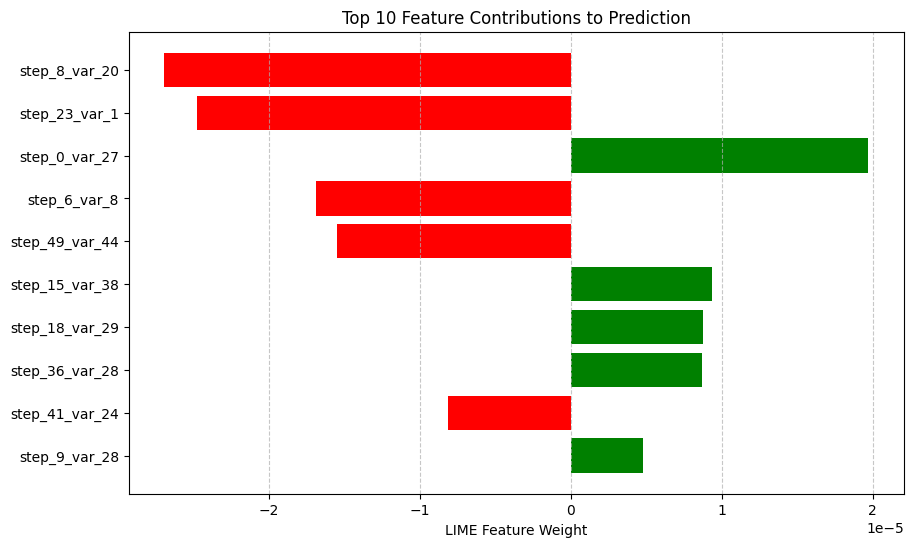

In [21]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
# Flatten a few sequences from training data
X_train_seq, _ = next(iter(train_ds))
X_train_flat = X_train_seq.numpy().reshape((X_train_seq.shape[0], -1))
X_test_seq, _ = next(iter(test_ds))
X_instance = X_test_seq[0].numpy().reshape(-1)

#reshapes 2D flat input back to 3D
def predict_fn(X_input):
    reshaped = X_input.reshape((-1, sequence, len(columns)))
    return model.predict(reshaped)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    mode="classification",
    feature_names=[f"step_{t}_var_{i}" for t in range(sequence) for i in range(len(columns))],
    class_names=[f"fault_{i:02d}" for i in range(classes)],
    discretize_continuous=False
)
exp = explainer.explain_instance(X_instance, predict_fn, num_features=10)

#extracting feature-weight pairs
features, weights = zip(*exp.as_list())

#reversing for horizontal bar plot (most important on top)
features = features[::-1]
weights = weights[::-1]

plt.figure(figsize=(10, 6))
colors = ['green' if w > 0 else 'red' for w in weights]
plt.barh(features, weights, color=colors)
plt.xlabel("LIME Feature Weight")
plt.title("Top 10 Feature Contributions to Prediction")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
